# STRATEGIA SU UNA SINGOLA COPPIA 

- [Cointegration](##Cointegrazione)
- [Parametri OU](##PARAMETRI-OU)
- [Spread e KF](##SPREAD-CON-KALMAN-FILTER)
- [Standardizzaziome](##STANDARDIZZAZIONE)
- [Hidden Markov Model](##HIDDEN-MARKOV-MODEL)
- [Trading Signals](##SEGNALI-TRADING)
- [Backtest](##BACKTEST)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pykalman import KalmanFilter
from hmmlearn.hmm import GaussianHMM

In [2]:
tickers = ['MA', 'V' ]  # Mastercard e VISA
entry_t = 0.6
exit_t = 0.5

data = yf.download(tickers, start="2020-01-01", end="2025-01-01", progress=False, auto_adjust=False)['Adj Close'] 

df = pd.DataFrame(data)
#df.to_csv("MA_V_2020-2025.csv")

df.shape

(1258, 2)

In [3]:
#df = pd.read_csv("./MA_V_2020-2025.csv", parse_dates=["Date"], index_col="Date")
df.head(10)

Ticker,MA,V
Date,,
2020-01-02,293.338470,183.549072
2020-01-03,290.476501,182.089310
2020-01-06,291.250061,181.695541
2020-01-07,290.263763,181.215302
2020-01-08,295.385437,184.317368
2020-01-09,299.258087,185.594696
2020-01-10,301.262177,186.094101
2020-01-13,305.173492,187.592316
2020-01-14,300.749023,188.283813


In [4]:
df.corr()

Ticker,MA,V
Ticker,,
MA,1.000000,0.983552
V,0.983552,1.000000


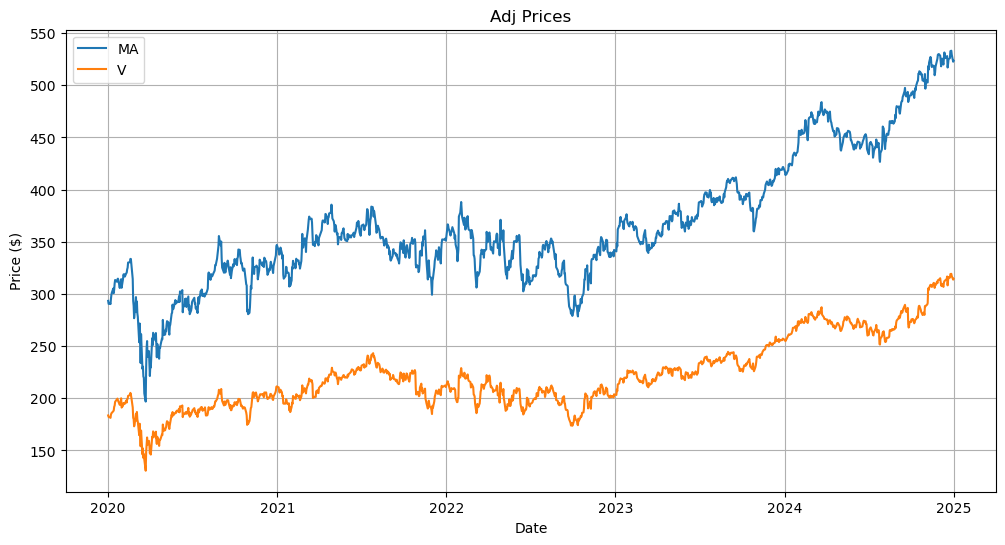

In [5]:
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)

plt.title("Adj Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid()
plt.show()

## Cointegrazione

In [6]:
# Cointegrazione e Spread

y = df.iloc[:, 0]
x = df.iloc[:, 1]

x = sm.add_constant(x)  # intercetta
model = sm.OLS(y, x).fit()
spread_OLS = model.resid  # residui = spread

adf_result = adfuller(spread_OLS)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'numero di lag: {adf_result[2]}')
print(f'Critical values: {adf_result[4]}')

ADF Statistic: -4.686861812669203
p-value: 8.90673775165722e-05
numero di lag: 10
Critical values: {'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


In [7]:
df['spread_OLS'] = spread_OLS
df.head()

Ticker,MA,V,spread_OLS
Date,,,
2020-01-02,293.338470,183.549072,-2.284633
2020-01-03,290.476501,182.089310,-2.486272
2020-01-06,291.250061,181.695541,-0.995094
2020-01-07,290.263763,181.215302,-1.106183
2020-01-08,295.385437,184.317368,-1.637838


In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MA   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 3.724e+04
Date:                Tue, 14 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:34:29   Log-Likelihood:                -4846.2
No. Observations:                1258   AIC:                             9696.
Df Residuals:                    1256   BIC:                             9707.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.8841      2.126    -18.287      0.000     -43.056     -34.713
V              1.8224      0.009    192.980      0.000       1.804       1.841
==============================================================================
Omnibus:                       17.636   Durbin-Watson:                   0.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.051
Skew:                           0.277   Prob(JB):                     0.000120
Kurtosis:                       3.196   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Parametri OU	

In [9]:
# Parametri Ornstein-Uhlenbeck
def estimate_ou_params(spread_OLS, dt=1.0, kappa_floor=1e-3):
    x = spread_OLS.values
    y = x[1:]
    x0 = x[:-1]

    # Regressione OLS discreta
    b, a = np.polyfit(x0, y, 1)
    if not (0 < b < 1):  # Verifica mean-reversion: 0 < b < 1
        return np.nan, np.nan, np.nan, np.nan

    # kappa e mu
    kappa = -np.log(b) / dt
    kappa = max(kappa, kappa_floor)
    mu    = a / (1 - b)

    # Varianza dei residui
    resid  = y - (b * x0 + a)
    omega2 = np.var(resid, ddof=1)

    # Sigma stazionario
    try:
        sigma = np.sqrt(2 * kappa * omega2 / (1 - np.exp(-2 * kappa * dt)))
    except (ValueError, ZeroDivisionError):
        return np.nan, np.nan, np.nan, np.nan

    # Half-life
    half_life = np.log(2) / kappa

    return kappa, mu, sigma, half_life

kappa, mu, sigma, half_life = estimate_ou_params(pd.Series(spread_OLS))

print("kappa:     ", kappa)
print("mu:        ", mu)
print("sigma:     ", sigma)
print("half-life: ", half_life)

kappa:      0.03385675505284509
mu:         -0.1900263650076533
sigma:      2.981801648267251
half-life:  20.472936035306724


## Spread con Kalman Filter


In [10]:
'''Kalman Filter'''

# Stima Q e R
def stima_QR_EM(df_train, em_iter=50):
    y = df_train.iloc[:, 0].values.reshape(-1, 1)
    x = df_train.iloc[:, 1].values
    n_obs = len(df_train)

    A = np.eye(2)
    H = np.zeros((n_obs, 1, 2))
    H[:, 0, 0] = 1.0
    H[:, 0, 1] = x

    kf = KalmanFilter(      # kf.em() 
        transition_matrices=A,
        observation_matrices=H,
        initial_state_mean=[0.0, 1.0],
        initial_state_covariance=np.eye(2) * 100
    ).em(y, n_iter=em_iter, em_vars=['transition_covariance', 'observation_covariance'])

    Q_hat = kf.transition_covariance.copy()
    R_hat = kf.observation_covariance.copy()
    return Q_hat, R_hat # --> controllare se converge!

N_train = 315
Q_hat, R_hat = stima_QR_EM(df.iloc[:N_train])




def kalman_spread(df, Q, R):        
    n_obs = len(df)
    y_vals = df.iloc[:,0].values
    x_vals = df.iloc[:,1].values 

    A = np.eye(2)                                    # Transition Matrix  

    # Observation matrices pre-computate
    observation_matrices = np.zeros((n_obs, 1, 2))
    observation_matrices[:, 0, 0] = 1.0
    observation_matrices[:, 0, 1] = x_vals

    kf = KalmanFilter(
        transition_matrices=A,
        observation_matrices=observation_matrices,  
        initial_state_mean=[0.0, 1.0],
        initial_state_covariance=np.eye(2) * 100,     # 100*I --> grande libertà ai parametri all'inizio
        transition_covariance = Q,                    # rumore di processo
        observation_covariance = R                    # rumore di osservazione
    )

    state_means, _ = kf.filter(y_vals.reshape(-1, 1))  # non usiamo smooth!
    alpha_t = state_means[:, 0]
    beta_t  = state_means[:, 1]
    spread  = y_vals - (alpha_t + beta_t * x_vals)
    return alpha_t, beta_t, spread




alpha_t, beta_t, spread_kf = kalman_spread(df, Q=Q_hat, R=R_hat)
df['alpha_t']   = alpha_t
df['beta_t']    = beta_t
df['spread_kf'] = spread_kf

In [11]:
print("Q: ", Q_hat)
print("R: ", R_hat)

Q:  [[ 1.62837199e+00 -1.89393477e-03]
 [-1.89393477e-03  1.05698750e-04]]
R:  [[2.2773974]]


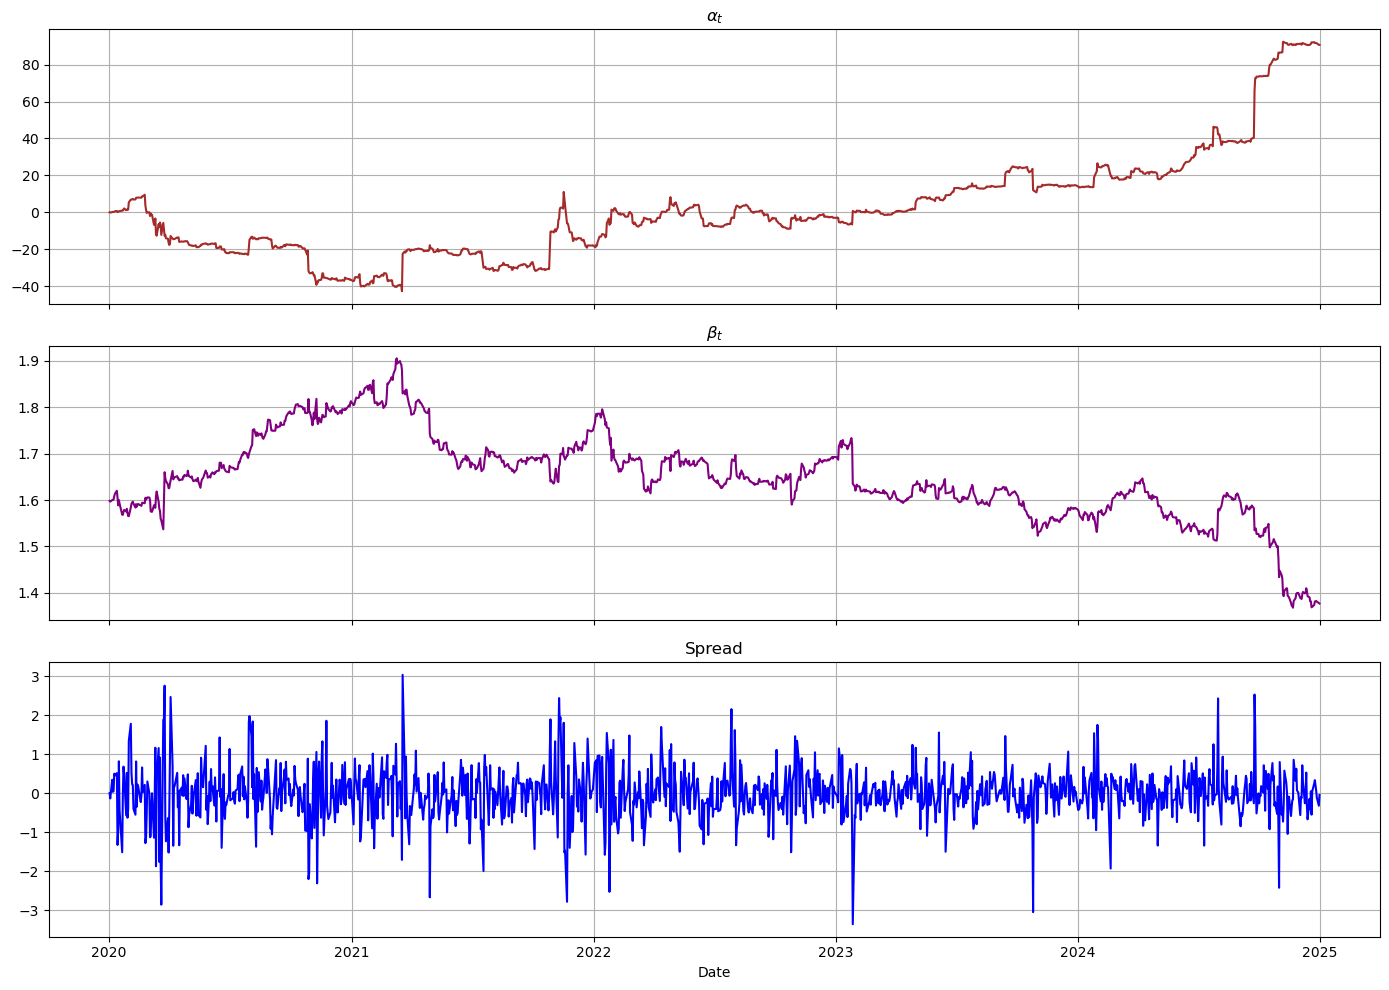

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(14,10), sharex=True)

# Alfa_t
ax[0].plot(df.index, df['alpha_t'], color='brown')
ax[0].set_title(r"$\alpha_t$")
ax[0].grid(True)

# Beta_t
ax[1].plot(df.index, df['beta_t'], color='purple')
ax[1].set_title(r"$\beta_t$")
ax[1].grid(True)

# Spread
ax[2].plot(df.index, df['spread_kf'], color='blue')
ax[2].set_title("Spread")
ax[2].set_xlabel("Date")
ax[2].grid(True)

plt.tight_layout()
plt.show()

In [13]:
df.head()

Ticker,MA,V,spread_OLS,alpha_t,beta_t,spread_kf
Date,,,,,,
2020-01-02,293.338470,183.549072,-2.284633,0.003259,1.598129,0.000074
2020-01-03,290.476501,182.089310,-2.486272,-0.119365,1.596635,-0.134335
2020-01-06,291.250061,181.695541,-0.995094,0.186957,1.600036,0.343699
2020-01-07,290.263763,181.215302,-1.106183,0.218678,1.600366,0.034331
2020-01-08,295.385437,184.317368,-1.637838,0.220784,1.601116,0.051194


## Standardizzazione

In [14]:
window_size = 60 # half life x2 o x3

rm = spread_OLS.mean()
rs = spread_OLS.std()
zscore = (spread_OLS - rm) / rs
zscore.bfill(inplace=True)
zscore.fillna(0, inplace=True)

spread_kf = df['spread_kf']
rm = spread_kf.rolling(window_size, min_periods=1).mean().shift(1)
rs = spread_kf.rolling(window_size, min_periods=1).std().shift(1)
zscore_kf = (spread_kf - rm) / rs
zscore_kf = zscore_kf.replace([np.inf, -np.inf], 0).fillna(0)


df['rolling_mean'] = rm
df['rolling_std'] = rs
df['z_OLS'] = zscore
df['z_kf'] = zscore_kf

df.head()

Ticker,MA,V,spread_OLS,alpha_t,beta_t,spread_kf,rolling_mean,rolling_std,z_OLS,z_kf
Date,,,,,,,,,,
2020-01-02,293.338470,183.549072,-2.284633,0.003259,1.598129,0.000074,NaN,NaN,-0.200383,0.000000
2020-01-03,290.476501,182.089310,-2.486272,-0.119365,1.596635,-0.134335,0.000074,NaN,-0.218069,0.000000
2020-01-06,291.250061,181.695541,-0.995094,0.186957,1.600036,0.343699,-0.067130,0.095042,-0.087279,4.322616
2020-01-07,290.263763,181.215302,-1.106183,0.218678,1.600366,0.034331,0.069813,0.246529,-0.097022,-0.143925
2020-01-08,295.385437,184.317368,-1.637838,0.220784,1.601116,0.051194,0.060942,0.202071,-0.143653,-0.048242


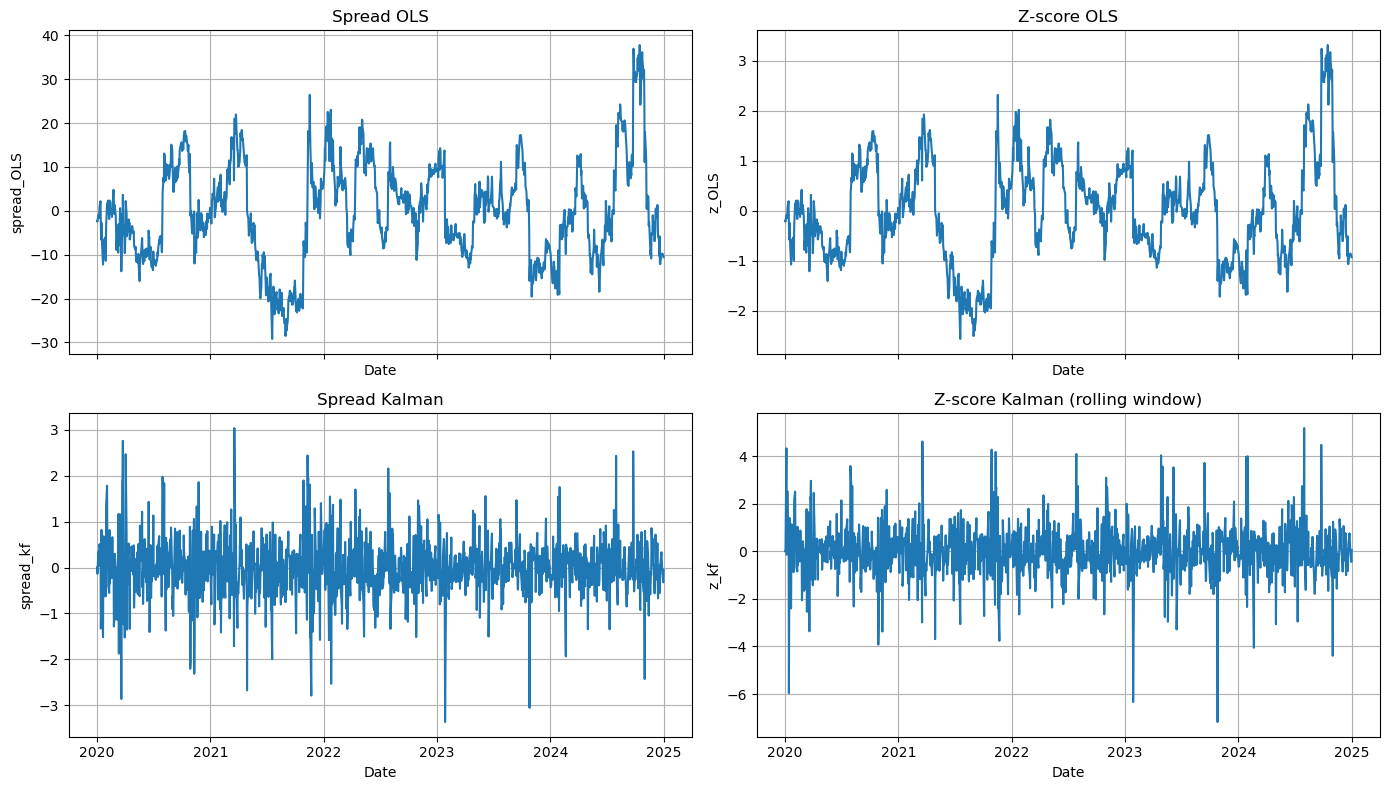

In [15]:
columns = ['spread_OLS', 'z_OLS', 'spread_kf', 'z_kf']
titles  = ['Spread OLS', 'Z-score OLS', 'Spread Kalman', 'Z-score Kalman (rolling window)']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), sharex=True)

axes = axes.flatten()

for ax, col, title in zip(axes, columns, titles):
    ax.plot(df[col])
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(col)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [16]:
kappa_kf, mu_kf, sigma_kf, half_life_kf = estimate_ou_params(pd.Series(spread_kf))
print("half-life su spread KF: ", half_life_kf)

half-life su spread KF:  0.368212443533782


In [17]:
df.drop(columns=['spread_OLS', 'z_OLS', 'spread_kf'], inplace=True)

In [18]:
df.head()

Ticker,MA,V,alpha_t,beta_t,rolling_mean,rolling_std,z_kf
Date,,,,,,,
2020-01-02,293.338470,183.549072,0.003259,1.598129,NaN,NaN,0.000000
2020-01-03,290.476501,182.089310,-0.119365,1.596635,0.000074,NaN,0.000000
2020-01-06,291.250061,181.695541,0.186957,1.600036,-0.067130,0.095042,4.322616
2020-01-07,290.263763,181.215302,0.218678,1.600366,0.069813,0.246529,-0.143925
2020-01-08,295.385437,184.317368,0.220784,1.601116,0.060942,0.202071,-0.048242


## Hidden Markov Model

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


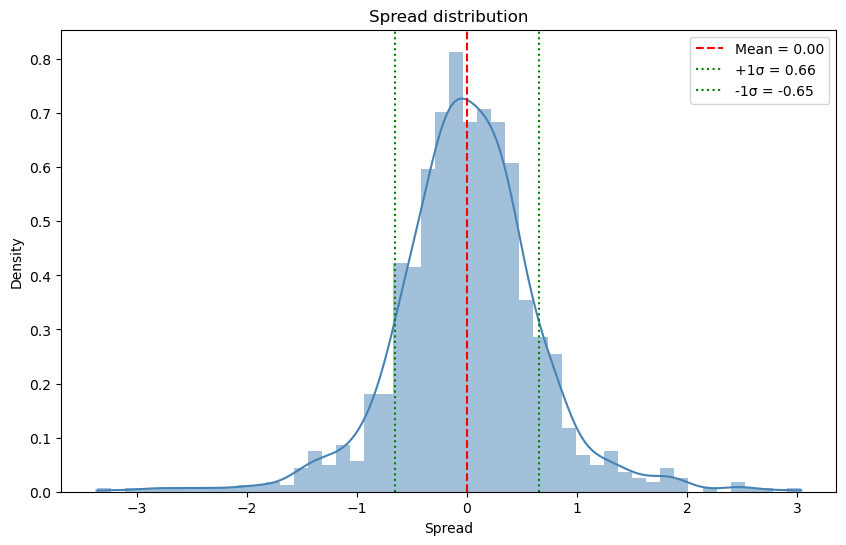

In [19]:
# distribuzione spread (verificare normalità)

def plot_spread_distribution(spread, bins=50):
    spread = np.asarray(spread)
    spread = spread[~np.isnan(spread)]  # rimuovi eventuali NaN
    
    plt.figure(figsize=(10,6))
    
    # Istogramma + kde
    sns.histplot(spread, bins=bins, kde=True, stat="density", color="steelblue", edgecolor=None)
    
    # Aggiungo media e ±1σ
    mu = np.mean(spread)
    sigma = np.std(spread)
    plt.axvline(mu, color="red", linestyle="--", label=f"Mean = {mu:.2f}")
    plt.axvline(mu+sigma, color="green", linestyle=":", label=f"+1σ = {mu+sigma:.2f}")
    plt.axvline(mu-sigma, color="green", linestyle=":", label=f"-1σ = {mu-sigma:.2f}")
    
    plt.title("Spread distribution")
    plt.xlabel("Spread")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_spread_distribution(spread_kf)

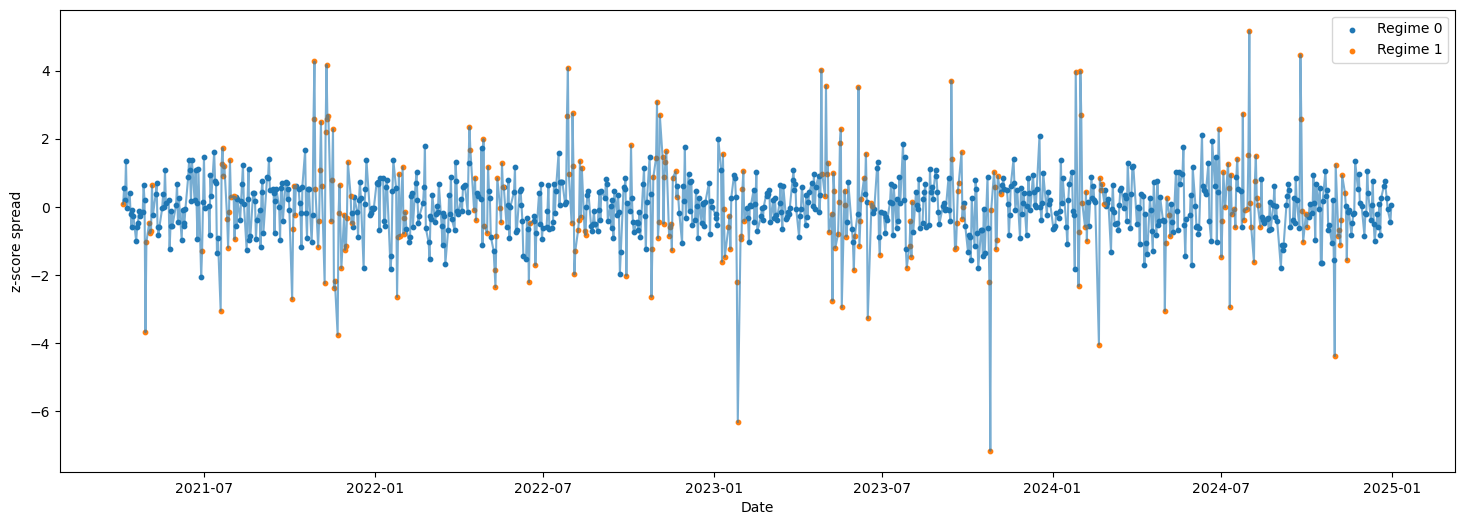

In [20]:
# addestramento modello

window = 315
zs = df['z_kf'].values.reshape(-1, 1)   # (T, 1)
n = len(zs)

model = GaussianHMM(
    n_components=2,
    covariance_type='diag',
    n_iter=200,
    tol=1e-4,    
    init_params="stmc"
)
model.fit(zs[:window])

state_vars = model.covars_.reshape(model.n_components, -1).sum(axis=1)
hi_var_state = int(np.argmax(state_vars))
def remap(state_arr):
    # 1 = high variance, 0 = low variance
    return np.where(state_arr == hi_var_state, 1, 0)

regimes = np.empty(n - window, dtype=int)

for i in range(n - window):
    # Sequenza fino a "oggi" (o usa una finestra scorrevole)
    seq = zs[i : i + window + 1]          # NO look-ahead
    states = model.predict(seq)           # Viterbi sulla sequenza
    regimes[i] = remap(states)[-1]        # ultimo stato = stato di "oggi"

df = df.iloc[window:].copy()
df['regime'] = regimes


plt.figure(figsize=(18, 6))
plt.plot(df.index, df['z_kf'], alpha=0.6)
for state in [0, 1]:
    mask = df['regime'] == state
    plt.scatter(
        df.index[mask],
        df['z_kf'][mask],
        s=10,
        label=f'Regime {state}'
    )
plt.xlabel('Date')
plt.ylabel('z-score spread')
plt.legend()
plt.show()

=== HMM Gaussian emissions (mapped to regime 0/1) ===
Regime 0 (Low-variance): mu = 0.0213, sigma = 0.6969
Regime 1 (High-variance): mu = -0.0148, sigma = 1.7497
Empirical regime 0: variance = 0.5093, std = 0.7136
Empirical regime 1: variance = 3.0017, std = 1.7325


/var/folders/3s/gk3lt8991f7_369kj0_7nn3r0000gn/T/ipykernel_6602/182017805.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


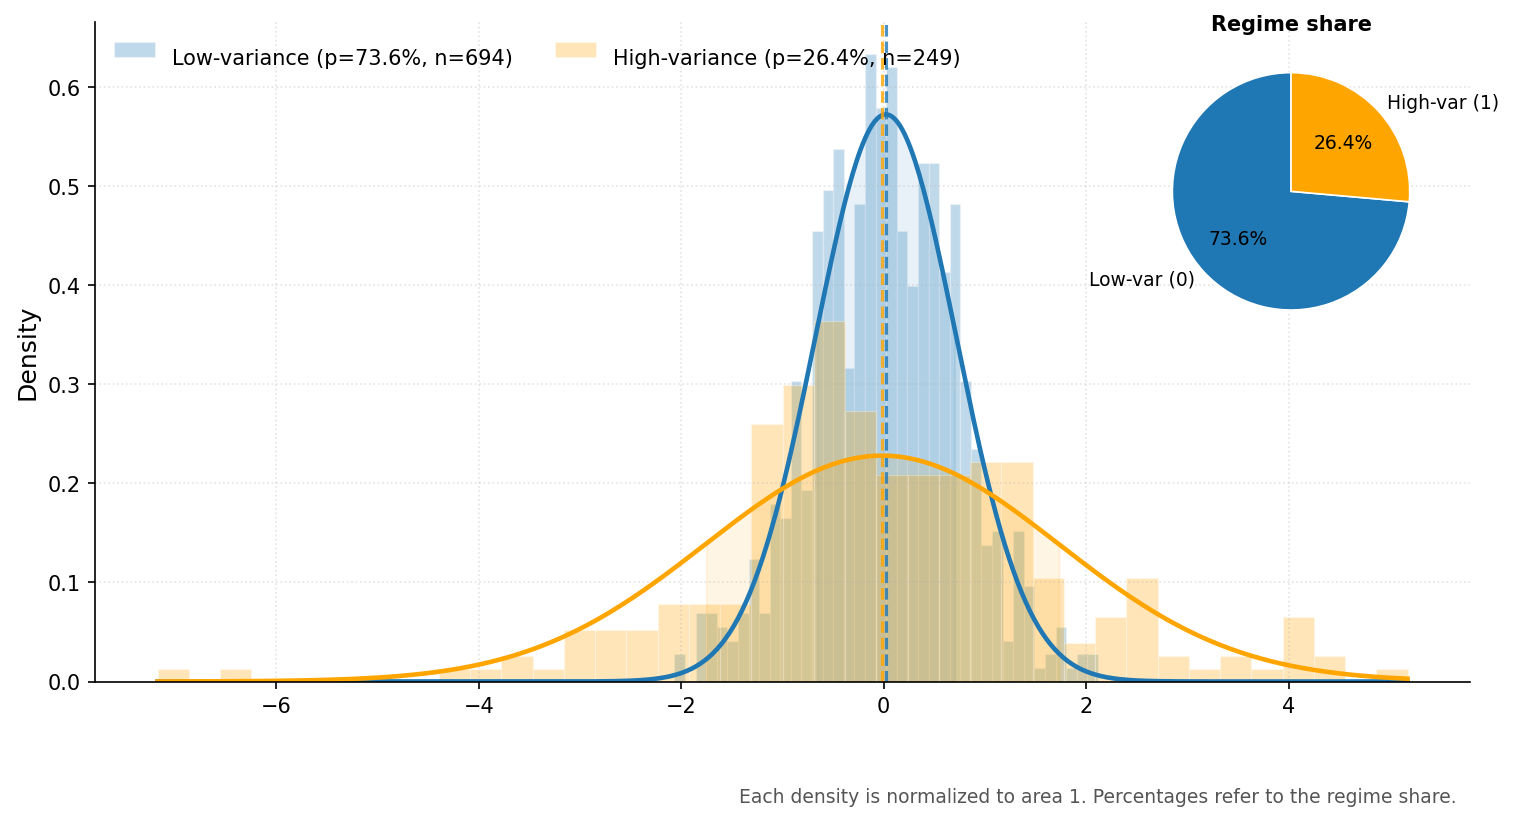

In [21]:
def plotHMM(df, model, feature_name='z_kf'):

    means_raw = np.asarray(model.means_).squeeze()         
    cov = np.asarray(model.covars_)
    cov = np.squeeze(cov)                                  
    if cov.ndim == 1:
        stds_raw = np.sqrt(cov)                          
    elif cov.ndim == 2:
        stds_raw = np.sqrt(cov[:, 0])
    else:
        stds_raw = np.sqrt(cov[:, 0, 0])


    low_var_state_model  = int(np.argmin(stds_raw))
    high_var_state_model = int(np.argmax(stds_raw))

    mu_map  = {0: float(means_raw[low_var_state_model]),  1: float(means_raw[high_var_state_model])}
    std_map = {0: float(stds_raw[low_var_state_model]),   1: float(stds_raw[high_var_state_model])}

    print("=== HMM Gaussian emissions (mapped to regime 0/1) ===")
    for s in (0, 1):
        lab = "Low-variance" if s == 0 else "High-variance"
        print(f"Regime {s} ({lab}): mu = {mu_map[s]:.4f}, sigma = {std_map[s]:.4f}")


    variances = df.groupby('regime')[feature_name].var()
    stds_emp  = df.groupby('regime')[feature_name].std()
    for state in variances.index:
        print(f"Empirical regime {state}: variance = {variances[state]:.4f}, std = {stds_emp[state]:.4f}")

    counts = df['regime'].value_counts().sort_index()
    pcts   = (counts / counts.sum() * 100).round(1)

    # plot
    plt.rcParams.update({
        "figure.dpi": 150, "axes.spines.top": False, "axes.spines.right": False,
        "axes.titleweight": "bold", "axes.grid": True, "grid.alpha": 0.35, "grid.linestyle": ":",
    })
    fig, ax = plt.subplots(figsize=(10, 5.5))
    colors = {0: "#1f77b4", 1: "orange"}

    x = np.linspace(df[feature_name].min(), df[feature_name].max(), 600)

    for s in (0, 1):
        data = df.loc[df['regime'] == s, feature_name].to_numpy()
        label = f'{"Low" if s==0 else "High"}-variance (p={pcts.get(s,0):.1f}%, n={int(counts.get(s,0))})'
        ax.hist(data, bins=40, density=True, alpha=0.28, label=label,
                color=colors[s], edgecolor="white", linewidth=0.6)

        m, sg = mu_map[s], std_map[s]
        pdf = (1.0 / (sg * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - m) / sg) ** 2)
        ax.plot(x, pdf, color=colors[s], linewidth=2.2)
        ax.axvline(m, color=colors[s], linestyle="--", linewidth=1.5, alpha=0.8)
        ax.fill_between(x, 0, pdf, where=(x >= m - sg) & (x <= m + sg),
                        color=colors[s], alpha=0.10)

    #ax.set_title("HMM Estimated State Distributions", fontsize=15)
    ax.set_ylabel("Density", fontsize=12)
    ax.text(0.99, -0.16,
            "Each density is normalized to area 1. Percentages refer to the regime share.",
            transform=ax.transAxes, ha="right", va="top", fontsize=9, color="#555")

    leg = ax.legend(frameon=False, fontsize=10, ncol=2, loc="upper left")
    for t in leg.get_texts():
        t.set_va("center_baseline")

    axins = inset_axes(ax, width="23%", height="45%", loc="upper right", borderpad=1.0)
    axins.set_title("Regime share", fontsize=10, pad=6)
    axins.pie([counts.get(0, 0), counts.get(1, 0)],
              labels=["Low-var (0)", "High-var (1)"],
              autopct="%1.1f%%", startangle=90,
              colors=[colors[0], colors[1]],
              wedgeprops={"edgecolor": "white", "linewidth": 0.8},
              textprops={"fontsize": 9})

    plt.tight_layout(); plt.show()


plotHMM(df, model)

In [22]:
# Matrice di transizione 2×2, calcolata all'ultimo step del loop
A = model.transmat_

print(A)

[[0.93675834 0.06324166]
 [0.03265013 0.96734987]]


## Segnali Trading


-    0 = close
-    1 = long  (buy MA, sell V)
-    -1 = short (sell MA, buy V)

In [23]:
def generate_signals(df, entry_thresh, exit_thresh, HMM=True):
    sig = np.zeros(len(df), dtype=int)
    position = 0

    for i in range(len(df)):
        z = df.loc[df.index[i], 'z_kf']
        regime = df.loc[df.index[i], 'regime']
        
        if HMM: # ACCESO
            if regime == 1: 
                position = 0           
            else:
                if position == 0:
                    # se non ho posizione, cerco quando entrare
                    if z >= entry_thresh:
                        position = -1  # spread alto → short 
                    elif z <= -entry_thresh:
                        position = 1   # spread basso → long 
                else:
                    # se ho già posizione, cerco quando uscire
                    if abs(z) < exit_thresh:
                        position = 0   # zscore ha ritracciato → chiudo
        else:   # SPENTO
                if position == 0:
                    if z >= entry_thresh:
                        position = -1  
                    elif z <= -entry_thresh:
                        position = 1   
                else:
                    if abs(z) < exit_thresh:
                        position = 0   
                    
        sig[i] = position

    return sig

### SEGNALI

In [24]:
#entry_t = 1.1
#exit_t = 0.3

df['signal'] = generate_signals(df, entry_thresh=entry_t, exit_thresh=exit_t, HMM=True) # !!!
df['position'] = df['signal'].shift(1).fillna(0)  # la posizione entra/esce il giorno dopo 

In [25]:
df.tail(10)

Ticker,MA,V,alpha_t,beta_t,rolling_mean,rolling_std,z_kf,regime,signal,position
Date,,,,,,,,,,
2024-12-17,527.976501,316.681213,90.954104,1.381315,-0.013299,0.683399,-0.586658,0,0,0.0
2024-12-18,516.989685,308.204559,91.189050,1.381399,-0.015864,0.684630,0.091991,0,0,0.0
2024-12-19,520.290649,313.278656,92.061607,1.368686,-0.057255,0.597615,-0.826180,0,1,0.0
2024-12-20,525.013550,316.094208,91.998636,1.369742,-0.094951,0.553938,0.257053,0,0,1.0
2024-12-23,525.938293,315.606689,92.126617,1.373753,-0.095296,0.553841,0.616588,0,-1,0.0
2024-12-24,532.649719,319.019257,91.680621,1.381218,-0.082561,0.552742,0.753670,0,-1,-1.0
2024-12-26,533.087097,319.277954,91.687513,1.382302,-0.076917,0.555275,0.248677,0,0,-1.0
2024-12-27,529.159729,317.039368,91.493508,1.380842,-0.071576,0.555032,-0.078527,0,0,0.0
2024-12-30,522.547729,313.706421,90.681115,1.377682,-0.073027,0.555030,-0.446897,0,0,0.0


In [26]:
#df.to_csv('MA_V_2020-2025_FINAL.csv')
df.shape

(943, 10)

## BACKTEST

CAGR: 4.81%
Ann. Volatility: 3.80%
Sharpe: 1.25
Sortino: 1.52
Max Drawdown: -6.23%
Calmar: 0.77
Kurtosis: 24.95839307302975


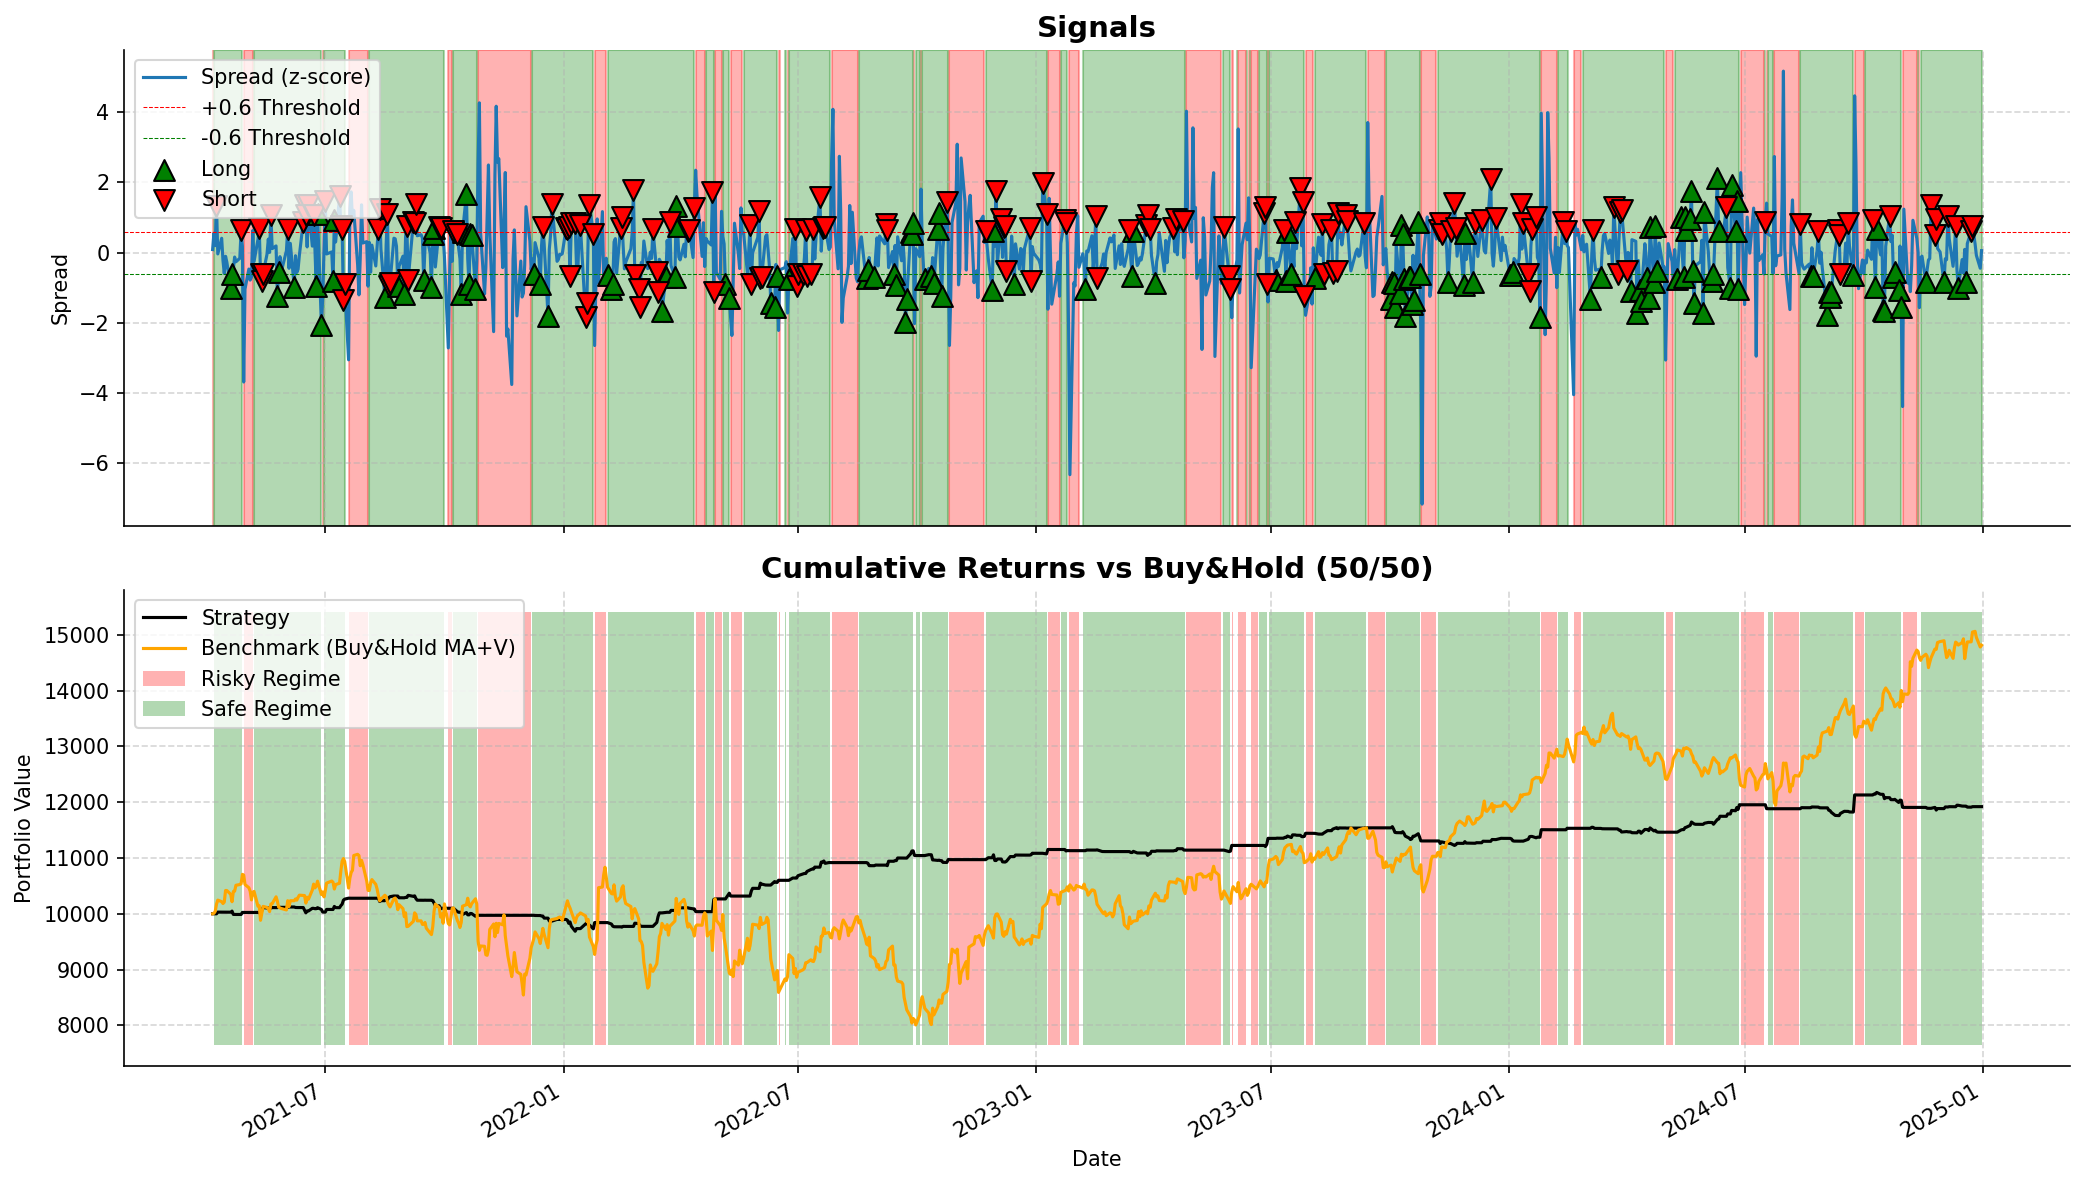

In [27]:
# 5. Backtest 
initial_capital = 10000.0
cost_bps = 0.0001  # 1 bps = 0.01% per lato
y_col, x_col = tickers[0], tickers[1]

df['r_y'] = df[y_col].pct_change().fillna(0.0)
df['r_x'] = df[x_col].pct_change().fillna(0.0)

beta_lag = df['beta_t'].shift(1).ffill()
beta_lag = beta_lag.clip(-10,10)
pos = df['position']              
gross = 1.0 + beta_lag.abs()       

# Pesi di portafoglio (long spread = +Y, -βX)
w_y =  pos / gross                  # +1/gross se long-spread, -1/gross se short-spread
w_x = -pos * beta_lag / gross       # -β/gross se long-spread, +β/gross se short-spread


ret_gross = w_y * df['r_y'] + w_x * df['r_x']
w_y_prev = w_y.shift(1).fillna(0.0)
w_x_prev = w_x.shift(1).fillna(0.0)
turnover = (w_y - w_y_prev).abs() + (w_x - w_x_prev).abs()
cost = cost_bps * turnover
df['strategy_ret'] = (ret_gross - cost).replace([np.inf, -np.inf], 0.0).fillna(0.0)


# Benchmark 50/50 semplice
bench_ret = (df['r_y'] + df['r_x']) / 2.0
df['benchmark_ret'] = bench_ret.fillna(0.0)

df['strategy_cum']  = (1.0 + df['strategy_ret']).cumprod() * initial_capital
df['benchmark_cum'] = (1.0 + df['benchmark_ret']).cumprod() * initial_capital

df['strategy_equity']   = df['strategy_cum']          # alias leggibile
df['benchmark_equity']  = df['benchmark_cum']

# PnL per periodo (in valuta): differenza di equity
df['strategy_pnl']   = df['strategy_equity'].diff().fillna(0.0)
df['benchmark_pnl']  = df['benchmark_equity'].diff().fillna(0.0)


# 6. Performance
def metrics(
    df: pd.DataFrame,
    ret_col: str = "strategy_ret",
    initial_capital: float = 100.0,
    rf_per_period: float = 0.00,   # risk-free per periodo 
    sortino_target: float = 0.0,  # target per-period per il Sortino (0 = MAR nullo)
    periods_per_year: int | None = None
):

    r = pd.Series(df[ret_col]).dropna().astype(float)
    if len(r) == 0:
        return {k: np.nan for k in ["CAGR","Ann. Volatility","Sharpe","Sortino","Max Drawdown","Calmar"]}

    # deduci periodi/anno se non specificato (fallback 252)
    if periods_per_year is None:
        periods_per_year = 252
        if isinstance(df.index, pd.DatetimeIndex) and len(df.index) > 1:
            periods_per_year = 252  # semplice e robusto per daily trading days

    # equity ricostruita dai rendimenti
    equity = (1 + r).cumprod() * float(initial_capital)

    # CAGR
    n_years = len(r) / periods_per_year
    cagr = (equity.iloc[-1] / float(initial_capital)) ** (1 / n_years) - 1 if n_years > 0 else np.nan

    # Volatilità annualizzata (std campionaria)
    ann_vol = r.std(ddof=1) * np.sqrt(periods_per_year)

    # Sharpe (unitless) su excess returns
    rex = r - rf_per_period
    sharpe = (rex.mean() * periods_per_year) / (rex.std(ddof=1) * np.sqrt(periods_per_year)) if rex.std(ddof=0) > 0 else np.nan

    # Sortino (unitless) con downside deviation vs target
    downside = r[r < sortino_target] - sortino_target
    downside_dev = downside.std(ddof=1) * np.sqrt(periods_per_year) if len(downside) > 1 else np.nan
    sortino = ((r.mean() - sortino_target) * periods_per_year) / downside_dev if (isinstance(downside_dev, float) and downside_dev > 0) else np.nan

    # Max Drawdown e Calmar
    roll_max = equity.cummax()
    drawdown = equity / roll_max - 1.0
    max_dd = float(drawdown.min())
    calmar = cagr / abs(max_dd) if max_dd < 0 else np.nan

    # Curtosi
    kurt = r.kurtosis()

    return {
        "CAGR": cagr,
        "Ann. Volatility": ann_vol,
        "Sharpe": sharpe,
        "Sortino": sortino,
        "Max Drawdown": max_dd,
        "Calmar": calmar,
        "Kurtosis": kurt
    }


m = metrics(df, ret_col="strategy_ret", initial_capital=100, rf_per_period=0.0)
for k, v in m.items():
    if k in {"CAGR","Ann. Volatility","Max Drawdown"} and pd.notna(v):
        print(f"{k}: {v:.2%}")
    elif k in {"Sharpe","Sortino","Calmar"} and pd.notna(v):
        print(f"{k}: {v:.2f}")
    else:
        print(f"{k}: {v}")


# ==============
# 6. PLOT

# Parametri
entry_thresh = 0.6  # !!!

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

x = df.index
in_regime = df['regime'] == 1  # ROSSO (high var)
out_regime = df['regime'] == 0 # VERDE (low var)

# --- Subplot 1: Spread con segnali e regimi ---
ymin1, ymax1 = df['z_kf'].min(), df['z_kf'].max()

# usa l’intero pannello in coordinate [0,1] sull’asse Y
ax1.fill_between(x, 0, 1, where=in_regime,  color='red',   alpha=0.3, transform=ax1.get_xaxis_transform())
ax1.fill_between(x, 0, 1, where=out_regime, color='green', alpha=0.3, transform=ax1.get_xaxis_transform())

ax1.plot(x, df['z_kf'], linewidth=1.5, label='Spread (z-score)')

ax1.axhline(entry_thresh, linestyle='--', linewidth=0.5, color='red',   label=f'+{entry_thresh} Threshold')
ax1.axhline(-entry_thresh, linestyle='--', linewidth=0.5, color='green', label=f'{-entry_thresh} Threshold')

long_idx  = df.index[df['signal'] ==  1]
short_idx = df.index[df['signal'] == -1]

ax1.scatter(long_idx,
            df.loc[long_idx, 'z_kf'],
            marker='^', s=100, edgecolor='k', facecolor='green', label='Long',  zorder=5)
ax1.scatter(short_idx,
            df.loc[short_idx, 'z_kf'],
            marker='v', s=100, edgecolor='k', facecolor='red',   label='Short', zorder=5)

ax1.set_title('Signals', fontsize=14)
ax1.set_ylabel('Spread')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.5)


# --- Subplot 2: Cumulative Returns con regimi ---
ax2.plot(x, df['strategy_cum'],  label="Strategy", color='black')
ax2.plot(x, df['benchmark_cum'], label="Benchmark (Buy&Hold MA+V)", color='orange')

ymin2, ymax2 = ax2.get_ylim()

ax2.fill_between(x, ymin2, ymax2, where=in_regime,  # regime==1 (alta varianza)
                 facecolor='red',  alpha=0.3, label="Risky Regime")
ax2.fill_between(x, ymin2, ymax2, where=out_regime, # regime==0 (bassa varianza)
                 facecolor='green', alpha=0.3, label="Safe Regime")

ax2.set_title('Cumulative Returns vs Buy&Hold (50/50)', fontsize=14)
ax2.set_ylabel('Portfolio Value')
ax2.set_xlabel('Date')
ax2.legend(loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.5)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()



/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


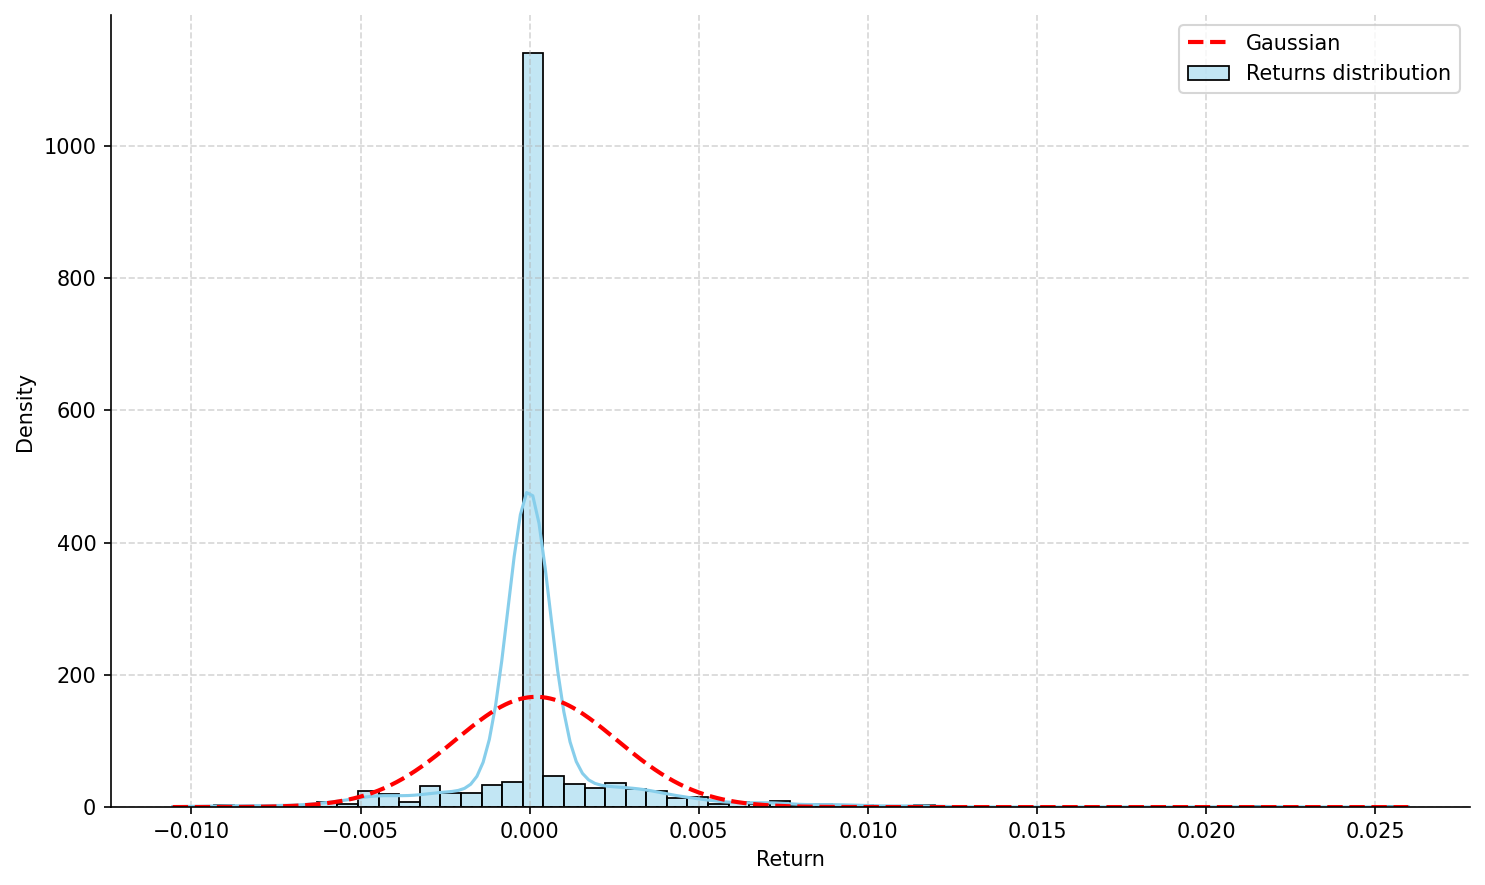

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


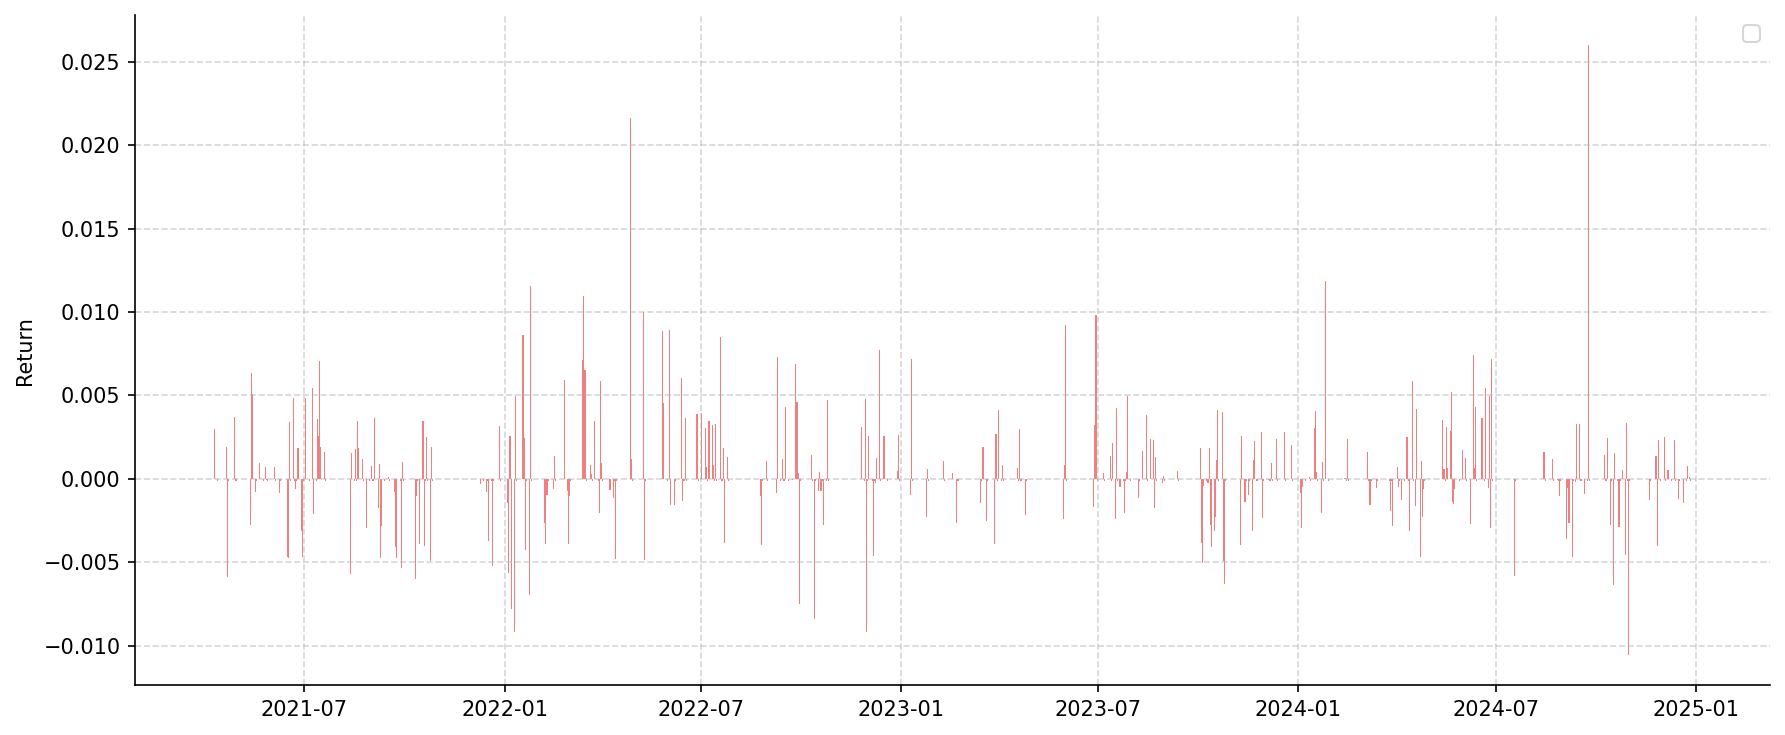

In [28]:
from scipy.stats import norm


r = df['strategy_ret'].dropna()
mu, sigma = r.mean(), r.std()

# === 1) Distribuzione dei rendimenti ===
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(r, bins=60, kde=True, color='skyblue', stat='density', label='Returns distribution', ax=ax)

x = np.linspace(r.min(), r.max(), 1000)
ax.plot(x, norm.pdf(x, mu, sigma), 'r--', linewidth=2, label='Gaussian')

ax.set_xlabel('Return')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 2) Rendimenti per periodo (time series) ===
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(r.index, r, width=1.0, color='lightcoral')
ax.set_ylabel('Return')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()

In [29]:
df

Ticker,MA,V,alpha_t,beta_t,rolling_mean,rolling_std,z_kf,regime,signal,position,r_y,r_x,strategy_ret,benchmark_ret,strategy_cum,benchmark_cum,strategy_equity,benchmark_equity,strategy_pnl,benchmark_pnl
Date,,,,,,,,,,,,,,,,,,,,
2021-04-05,358.491058,211.986496,-20.343778,1.786448,0.064290,0.786026,0.086219,1,0,0.0,0.000000,0.000000,0.000000,0.000000,10000.000000,10000.000000,10000.000000,10000.000000,0.000000,0.000000
2021-04-06,359.707733,211.609085,-20.081442,1.792493,0.051645,0.778573,0.551920,0,0,0.0,0.003394,-0.001780,0.000000,0.000807,10000.000000,10008.067621,10000.000000,10008.067621,0.000000,8.067621
2021-04-07,361.177399,212.209152,-19.993887,1.795228,0.053655,0.779539,0.197376,0,0,0.0,0.004086,0.002836,0.000000,0.003461,10000.000000,10042.702819,10000.000000,10042.702819,0.000000,34.635198
2021-04-08,368.096191,213.593048,-19.921401,1.811510,0.051629,0.778969,1.335017,0,-1,0.0,0.019156,0.006521,0.000000,0.012839,10000.000000,10171.639043,10000.000000,10171.639043,0.000000,128.936224
2021-04-09,370.376404,215.354446,-19.928868,1.812190,0.072533,0.789874,-0.038449,0,0,-1.0,0.006195,0.008247,0.003010,0.007221,10030.100855,10245.084000,10030.100855,10245.084000,30.100855,73.444957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,532.649719,319.019257,91.680621,1.381218,-0.082561,0.552742,0.753670,0,-1,-1.0,0.012761,0.010813,0.000782,0.011787,11919.756850,15048.662176,11919.756850,15048.662176,9.311417,175.309110
2024-12-26,533.087097,319.277954,91.687513,1.382302,-0.076917,0.555275,0.248677,0,0,-1.0,0.000821,0.000811,0.000125,0.000816,11921.249988,15060.942269,11921.249988,15060.942269,1.493138,12.280093
2024-12-27,529.159729,317.039368,91.493508,1.380842,-0.071576,0.555032,-0.078527,0,0,0.0,-0.007367,-0.007011,-0.000100,-0.007189,11920.057863,14952.664488,11920.057863,14952.664488,-1.192125,-108.277781


In [30]:
import vectorbt as vbt

# Prezzi
y_ticker, x_ticker = tickers[:2]                
prices = df[[y_ticker, x_ticker]].astype(float)

# Pesi
beta_lag = df['beta_t'].shift(1).ffill().clip(-10, 10)
pos = df['signal'].fillna(0.0) # vbt fa già lo shift(1) --> usare df[signal]
gross = 1.0 + beta_lag.abs()

w_y =  pos / gross
w_x = -pos * beta_lag / gross

weights = pd.DataFrame({
    y_ticker: w_y,
    x_ticker: w_x
}, index=prices.index).fillna(0.0)


# BT
pf = vbt.Portfolio.from_orders(
    close=prices,
    size=weights,
    size_type='targetpercent',
    init_cash=10_000,
    fees=0.0001,
    cash_sharing=True,
    freq='1D'
)

print(pf.stats())
pf.plot().show()


Start                               2021-04-05 00:00:00
End                                 2024-12-31 00:00:00
Period                                943 days 00:00:00
Start Value                                     10000.0
End Value                                   11916.23427
Total Return [%]                              19.162343
Benchmark Return [%]                          47.186386
Max Gross Exposure [%]                       124.954094
Total Fees Paid                              344.306011
Max Drawdown [%]                               6.228525
Max Drawdown Duration                 169 days 00:00:00
Total Trades                                        457
Total Closed Trades                                 457
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  53.610503
Best Trade [%]                                 9.705542
Worst Trade [%]                              -10

/opt/anaconda3/lib/python3.11/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning: Subplot 'orders' does not support grouped data
  warnings.warn(warning_message)
/opt/anaconda3/lib/python3.11/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning: Subplot 'trade_pnl' does not support grouped data
  warnings.warn(warning_message)


In [31]:
days_in_position = (df['signal'] != 0).sum()
total_days = len(df)
activity_ratio = (days_in_position / total_days) * 100
print('days in position: ', days_in_position)
print('activity ratio: ', activity_ratio)

days in position:  306
activity ratio:  32.44962884411453


### GRID SEARCH SOGLIE

In [32]:
'''
y_ticker, x_ticker = tickers[:2]
prices = df[[y_ticker, x_ticker]].astype(float)

# --- range parametri ---
entry_range = np.round(np.arange(0.3, 2.1, 0.1), 2)
exit_range  = np.round(np.arange(0.1, 2.1, 0.1), 2)

# --- helper per estrarre Sharpe ---
def get_sharpe(stats_s):
    for k in ['Sharpe Ratio', 'Sharpe', 'Sharpe Ratio (annualized)', 'Sharpe Annualized']:
        if k in stats_s.index:
            return float(stats_s[k])
    return np.nan


# --- grid search ---
sharpe_mat = pd.DataFrame(index=exit_range, columns=entry_range, dtype=float)

for entry_th in entry_range:
    for exit_th in exit_range:
        if exit_th >= entry_th:
            sharpe_mat.loc[exit_th, entry_th] = np.nan
            continue

        sig_arr = generate_signals(df, entry_th, exit_th, HMM=True) #!!!!
        pos = pd.Series(sig_arr, index=df.index).astype(float).fillna(0.0)

        beta_lag = df['beta_t'].shift(1).ffill().clip(-10, 10)
        gross = 1.0 + beta_lag.abs()
        w_y = pos / gross
        w_x = -pos * beta_lag / gross

        weights = pd.DataFrame({
            y_ticker: w_y,
            x_ticker: w_x
        }, index=prices.index).fillna(0.0)

        pf = vbt.Portfolio.from_orders(
            close=prices,
            size=weights,
            size_type='targetpercent',
            init_cash=10_000,
            fees=0.0001,
            cash_sharing=True,
            freq='1D'
        )

        sharpe_mat.loc[exit_th, entry_th] = get_sharpe(pf.stats())


# --- migliore combinazione ---
best = sharpe_mat.stack().sort_values(ascending=False)
if len(best) > 0:
    (best_exit, best_entry), best_sharpe = best.index[0], best.iloc[0]
    print(f"Miglior coppia: entry={best_entry}, exit={best_exit}, Sharpe={best_sharpe:.3f}")
# statistiche riassuntive
mean_sharpe = sharpe_mat.stack().mean()
median_sharpe = sharpe_mat.stack().median()
print(f"Sharpe medio: {mean_sharpe:.3f}")
print(f"Sharpe mediano: {median_sharpe:.3f}")


# --- heatmap ---
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    sharpe_mat,
    annot=False,
    cmap="viridis",
    cbar=True,
    vmin=-1, vmax=1.5
)

# inverti l’asse y per avere entrambe le soglie crescenti verso destra/alto
ax.invert_yaxis()

# X rossa + testo con soglie
if len(best) > 0:
    y_idx = list(sharpe_mat.index).index(best_exit)
    x_idx = list(sharpe_mat.columns).index(best_entry)
    plt.scatter(x_idx + 0.5, y_idx + 0.5, color='red', marker='X', s=200)
    plt.text(
        x_idx + 0.6, y_idx + 0.4,
        f"entry={best_entry}\nexit={best_exit}\nS.={best_sharpe:.2f}",
        color='black', fontsize=10, weight='bold'
    )

plt.xlabel("entry |z|")
plt.ylabel("exit |z|")
plt.tight_layout()
plt.show()
'''


'\ny_ticker, x_ticker = tickers[:2]\nprices = df[[y_ticker, x_ticker]].astype(float)\n\n# --- range parametri ---\nentry_range = np.round(np.arange(0.3, 2.1, 0.1), 2)\nexit_range  = np.round(np.arange(0.1, 2.1, 0.1), 2)\n\n# --- helper per estrarre Sharpe ---\ndef get_sharpe(stats_s):\n    for k in [\'Sharpe Ratio\', \'Sharpe\', \'Sharpe Ratio (annualized)\', \'Sharpe Annualized\']:\n        if k in stats_s.index:\n            return float(stats_s[k])\n    return np.nan\n\n\n# --- grid search ---\nsharpe_mat = pd.DataFrame(index=exit_range, columns=entry_range, dtype=float)\n\nfor entry_th in entry_range:\n    for exit_th in exit_range:\n        if exit_th >= entry_th:\n            sharpe_mat.loc[exit_th, entry_th] = np.nan\n            continue\n\n        sig_arr = generate_signals(df, entry_th, exit_th, HMM=True) #!!!!\n        pos = pd.Series(sig_arr, index=df.index).astype(float).fillna(0.0)\n\n        beta_lag = df[\'beta_t\'].shift(1).ffill().clip(-10, 10)\n        gross = 1.0 + 